In [2]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch import optim
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import copy

# from torchvision.models import resnet50, ResNet50_Weights

torch.manual_seed(0)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class LeNet(nn.Module):
    def __init__(self, max_growth):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc1 = nn.Linear(400,500+max_growth)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500+max_growth,100+max_growth)
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(100+max_growth,10)

        #Custom Functionality
        self.max_growth = max_growth
        previous_module = self.parameters_to_prune()[0][0]

        for module, name in self.parameters_to_prune()[1:]:

          #Prune incoming weights (Previous layers outgoing weights)
          if previous_module != None:
            mask = torch.ones(np.shape(previous_module.weight))
            mask[-max_growth:,:] = 0
            prune.custom_from_mask(previous_module, name, mask)
            
          #Prune outgoing weights
          mask = torch.ones(np.shape(module.weight))
          mask[:,-max_growth:] = 0
          prune.custom_from_mask(module, name, mask)

          previous_module = module  #save layer for next iteration
        

    def parameters_to_prune(self):
        return ((self.fc1, 'weight'),
                (self.fc2, 'weight'),
                (self.fc3, 'weight'),) 
    #End Custom Functionality

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu1(out)
        out = self.fc3(out)
        return out

In [4]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001

#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.CIFAR10(root = 'private/cifar/',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.CIFAR10(root = 'private/cifar/',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

augmented_train_dataset = torchvision.datasets.CIFAR10(root = 'private/cifar/',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.RandomVerticalFlip(p=1),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)

augmented_train_loader = torch.utils.data.DataLoader(dataset = augmented_train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

augmented_test_dataset = torchvision.datasets.CIFAR10(root = 'private/cifar/',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.RandomVerticalFlip(p=1),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


augmented_test_loader = torch.utils.data.DataLoader(dataset = augmented_test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


# train_dataset, test_dataset = train_dataset.cuda(), test_dataset.cuda()

#Setting the loss function
cost = nn.CrossEntropyLoss()

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

def train(model,train_loader,test_loader,num_epochs,optimizer):
#   model.to(device)
  total_step = len(train_loader)
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader): 
          
          images = images.to(device)
          labels = labels.to(device)
          
          #Forward pass
          outputs = model(images)
          loss = cost(outputs, labels)
            
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
              
          if (i+1) % 400 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
  
def test(model, test_loader):
    print("model: ",type(model))
    print("test_loader: ",type(test_loader))
    # model.to(device)
    # test_loader.to(device)
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader): 
            images, labels = images.cuda(), labels.cuda()
            # model=model.to(device)
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    return accuracy

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
#All in One Method to Find Lottery Tickets given a model and dataset, saves models in shared drive
def find_ticket(model, name, train_loader, test_loader, start_iter = 0, end_iter = 30, num_epochs = 10, learning_rate = .001, prune_amount = .2, k = 3):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  #If training has already been saved
  try:
    model.load_state_dict(torch.load('private/cifar/models/'+ name + '_RewindWeights' + '_' + str(k)))
  except:
    train(model, train_loader,test_loader,num_epochs = k, optimizer = optimizer)  #Save Kth epoch model
    torch.save(model.state_dict(), 'private/cifar/models/' + name + '_RewindWeights' + '_' + str(k))

  model_rewind = LeNet(max_growth = model.max_growth) #Save as separate model so we can rewind our weights back to this
  model_rewind.load_state_dict(torch.load('private/cifar/models/'+ name + '_RewindWeights' + '_' + str(k)))

  train(model, train_loader,test_loader,num_epochs = num_epochs - k, optimizer = optimizer) #Finish off training
  accuracy = []

  for i in range(start_iter, end_iter): 
    #Prune
    prune.global_unstructured(model.parameters_to_prune(),pruning_method=prune.L1Unstructured,amount=prune_amount,)
    
    #Rewind Weights
    for idx, (module, _) in enumerate(model.parameters_to_prune()):
      with torch.no_grad():
        module_rewind = model_rewind.parameters_to_prune()[idx][0]
        module.weight_orig.copy_(module_rewind.weight)

    print(
    "Global Sparsity: {:.2f}%".format(
        100. * (float(torch.sum(model.fc3.weight == 0)) + float(torch.sum(model.fc1.weight == 0)) + float(torch.sum(model.fc2.weight == 0)))
        / (float(model.fc3.weight.nelement()) + float(model.fc1.weight.nelement()) + float(model.fc2.weight.nelement()))
    )
    )
    
    #Train
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, train_loader,test_loader,num_epochs = num_epochs, optimizer = optimizer)
    accuracy.append(test(model, test_loader))

    plt.plot(np.arange(len(accuracy)), accuracy)
    plt.show()
    print('Saving iteration ', str(i+1))
    torch.save(model.state_dict(), 'private/cifar/models/' + name + '_iter' + str(i+1)) 

def grow(model, parameters_to_prune, amount):
  previous_module = parameters_to_prune[0][0]

  for module, name in parameters_to_prune[1:]:
    mask = module.get_buffer('weight_mask').data
    #Pick Suitable Locations
    omega = []
    for idx, val in enumerate(torch.sum(mask, dim = 0)): 
      if val == 0:
        omega.append(idx)

    indices = np.random.choice(omega, size = min(len(omega), amount), replace = False)
    
    #Grow at these indices
    module.get_buffer('weight_mask')[:,indices] = 1
    prune.custom_from_mask(module,'weight', torch.ones(module.weight.size()))

    previous_module.get_buffer('weight_mask')[indices,:] = 1
    prune.custom_from_mask(previous_module,'weight', torch.ones(previous_module.weight.size()))  

In [12]:
max_growth = 20
num_epochs = 50
gamma = 10 #num new nodes on first growth

model2 = LeNet(max_growth = max_growth)
model2=model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

train(model2, train_loader,test_loader,num_epochs, optimizer = optimizer)





Epoch [1/50], Step [400/782], Loss: 1.3379
Epoch [2/50], Step [400/782], Loss: 1.0961
Epoch [3/50], Step [400/782], Loss: 0.8307
Epoch [4/50], Step [400/782], Loss: 1.1127
Epoch [5/50], Step [400/782], Loss: 0.7361
Epoch [6/50], Step [400/782], Loss: 0.7005
Epoch [7/50], Step [400/782], Loss: 1.0522
Epoch [8/50], Step [400/782], Loss: 0.6481
Epoch [9/50], Step [400/782], Loss: 0.5580
Epoch [10/50], Step [400/782], Loss: 0.4615
Epoch [11/50], Step [400/782], Loss: 0.3758
Epoch [12/50], Step [400/782], Loss: 0.5004
Epoch [13/50], Step [400/782], Loss: 0.3494
Epoch [14/50], Step [400/782], Loss: 0.4192
Epoch [15/50], Step [400/782], Loss: 0.2126
Epoch [16/50], Step [400/782], Loss: 0.3230
Epoch [17/50], Step [400/782], Loss: 0.2806
Epoch [18/50], Step [400/782], Loss: 0.2706
Epoch [19/50], Step [400/782], Loss: 0.1766
Epoch [20/50], Step [400/782], Loss: 0.1609
Epoch [21/50], Step [400/782], Loss: 0.2422
Epoch [22/50], Step [400/782], Loss: 0.1356
Epoch [23/50], Step [400/782], Loss: 0.15

In [13]:
test(model2,test_loader)

model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.50


0.5

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/9], Step [400/782], Loss: 1.0603
Epoch [2/9], Step [400/782], Loss: 0.7565
Epoch [3/9], Step [400/782], Loss: 1.1451
Epoch [4/9], Step [400/782], Loss: 0.7391
Epoch [5/9], Step [400/782], Loss: 0.7625
Epoch [6/9], Step [400/782], Loss: 0.7940
Epoch [7/9], Step [400/782], Loss: 0.4060
Epoch [8/9], Step [400/782], Loss: 0.4331
Epoch [9/9], Step [400/782], Loss: 0.4144
Global Sparsity: 33.95%
Epoch [1/12], Step [400/782], Loss: 1.2113
Epoch [2/12], Step [400/782], Loss: 0.9753
Epoch [3/12], Step [400/782], Loss: 0.9920
Epoch [4/12], Step [400/782], Loss: 0.7080
Epoch [5/12], Step [400/782], Loss: 1.0474
Epoch [6/12], Step [400/782], Loss: 0.5040
Epoch [7/12], Step [400/782], Loss: 0.8563
Epoch [8/12], Step [400/782], Loss: 0.5984
Epoch [9/12], Step [400/782], Loss: 0.3672
Epoch [10/12], Step [400/782], Loss: 0.5026
Epoch [11/12], Step [400/782], Loss: 0.2629
Epoch [12/12], Step [400/782], Loss: 0.2793
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloa

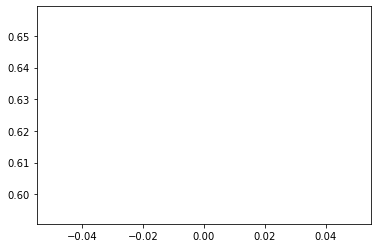

Saving iteration  1
Global Sparsity: 47.16%
Epoch [1/12], Step [400/782], Loss: 1.1242
Epoch [2/12], Step [400/782], Loss: 0.9569
Epoch [3/12], Step [400/782], Loss: 0.8563
Epoch [4/12], Step [400/782], Loss: 0.6616
Epoch [5/12], Step [400/782], Loss: 0.6531
Epoch [6/12], Step [400/782], Loss: 0.6229
Epoch [7/12], Step [400/782], Loss: 0.5537
Epoch [8/12], Step [400/782], Loss: 0.4831
Epoch [9/12], Step [400/782], Loss: 0.3825
Epoch [10/12], Step [400/782], Loss: 0.4551
Epoch [11/12], Step [400/782], Loss: 0.4996
Epoch [12/12], Step [400/782], Loss: 0.1871
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.62


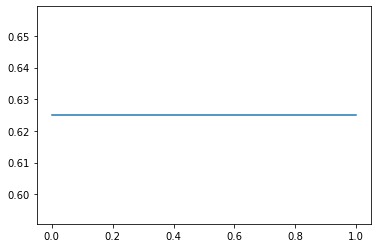

Saving iteration  2
Global Sparsity: 57.73%
Epoch [1/12], Step [400/782], Loss: 1.1402
Epoch [2/12], Step [400/782], Loss: 0.8049
Epoch [3/12], Step [400/782], Loss: 0.8728
Epoch [4/12], Step [400/782], Loss: 0.6839
Epoch [5/12], Step [400/782], Loss: 0.5651
Epoch [6/12], Step [400/782], Loss: 0.4499
Epoch [7/12], Step [400/782], Loss: 0.2146
Epoch [8/12], Step [400/782], Loss: 0.2099
Epoch [9/12], Step [400/782], Loss: 0.1204
Epoch [10/12], Step [400/782], Loss: 0.1656
Epoch [11/12], Step [400/782], Loss: 0.2287
Epoch [12/12], Step [400/782], Loss: 0.0697
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.56


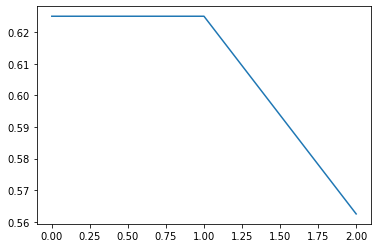

Saving iteration  3
Global Sparsity: 66.18%
Epoch [1/12], Step [400/782], Loss: 0.9691
Epoch [2/12], Step [400/782], Loss: 0.8861
Epoch [3/12], Step [400/782], Loss: 0.7986
Epoch [4/12], Step [400/782], Loss: 0.6268
Epoch [5/12], Step [400/782], Loss: 0.4599
Epoch [6/12], Step [400/782], Loss: 0.2819
Epoch [7/12], Step [400/782], Loss: 0.3231
Epoch [8/12], Step [400/782], Loss: 0.1679
Epoch [9/12], Step [400/782], Loss: 0.2279
Epoch [10/12], Step [400/782], Loss: 0.1924
Epoch [11/12], Step [400/782], Loss: 0.2452
Epoch [12/12], Step [400/782], Loss: 0.1252
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.56


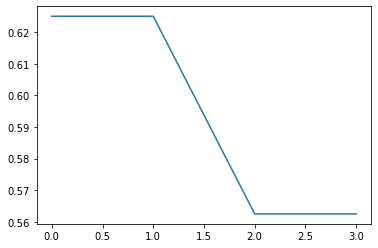

Saving iteration  4
Global Sparsity: 72.94%
Epoch [1/12], Step [400/782], Loss: 0.9353
Epoch [2/12], Step [400/782], Loss: 0.4756
Epoch [3/12], Step [400/782], Loss: 0.7127
Epoch [4/12], Step [400/782], Loss: 0.4468
Epoch [5/12], Step [400/782], Loss: 0.2823
Epoch [6/12], Step [400/782], Loss: 0.2870
Epoch [7/12], Step [400/782], Loss: 0.2335
Epoch [8/12], Step [400/782], Loss: 0.1644
Epoch [9/12], Step [400/782], Loss: 0.1117
Epoch [10/12], Step [400/782], Loss: 0.1400
Epoch [11/12], Step [400/782], Loss: 0.2917
Epoch [12/12], Step [400/782], Loss: 0.0863
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.62


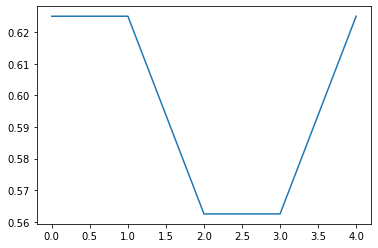

Saving iteration  5
Global Sparsity: 78.36%
Epoch [1/12], Step [400/782], Loss: 1.0327
Epoch [2/12], Step [400/782], Loss: 0.5549
Epoch [3/12], Step [400/782], Loss: 0.4381
Epoch [4/12], Step [400/782], Loss: 0.3045
Epoch [5/12], Step [400/782], Loss: 0.4497
Epoch [6/12], Step [400/782], Loss: 0.4362
Epoch [7/12], Step [400/782], Loss: 0.1970
Epoch [8/12], Step [400/782], Loss: 0.1175
Epoch [9/12], Step [400/782], Loss: 0.0974
Epoch [10/12], Step [400/782], Loss: 0.1770
Epoch [11/12], Step [400/782], Loss: 0.0427
Epoch [12/12], Step [400/782], Loss: 0.1063
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.69


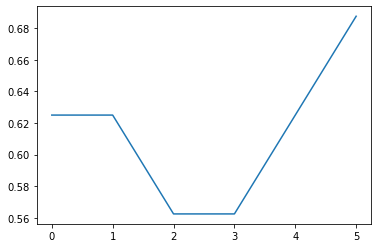

Saving iteration  6
Global Sparsity: 82.68%
Epoch [1/12], Step [400/782], Loss: 0.8163
Epoch [2/12], Step [400/782], Loss: 0.6155
Epoch [3/12], Step [400/782], Loss: 0.2975
Epoch [4/12], Step [400/782], Loss: 0.2557
Epoch [5/12], Step [400/782], Loss: 0.2223
Epoch [6/12], Step [400/782], Loss: 0.1931
Epoch [7/12], Step [400/782], Loss: 0.2080
Epoch [8/12], Step [400/782], Loss: 0.1838
Epoch [9/12], Step [400/782], Loss: 0.1109
Epoch [10/12], Step [400/782], Loss: 0.0804
Epoch [11/12], Step [400/782], Loss: 0.0770
Epoch [12/12], Step [400/782], Loss: 0.0877
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.50


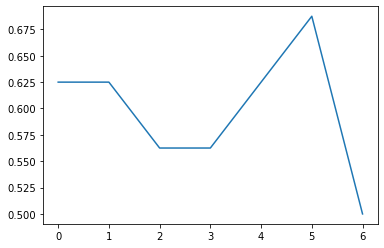

Saving iteration  7
Global Sparsity: 86.15%
Epoch [1/12], Step [400/782], Loss: 0.9138
Epoch [2/12], Step [400/782], Loss: 0.8053
Epoch [3/12], Step [400/782], Loss: 0.5510
Epoch [4/12], Step [400/782], Loss: 0.2361
Epoch [5/12], Step [400/782], Loss: 0.1765
Epoch [6/12], Step [400/782], Loss: 0.3252
Epoch [7/12], Step [400/782], Loss: 0.1250
Epoch [8/12], Step [400/782], Loss: 0.1116
Epoch [9/12], Step [400/782], Loss: 0.2696
Epoch [10/12], Step [400/782], Loss: 0.0960
Epoch [11/12], Step [400/782], Loss: 0.0679
Epoch [12/12], Step [400/782], Loss: 0.0960
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.75


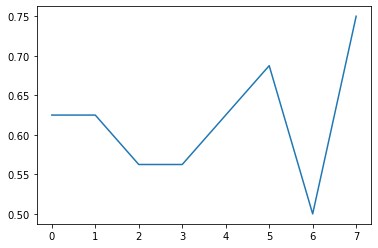

Saving iteration  8
Global Sparsity: 88.92%
Epoch [1/12], Step [400/782], Loss: 0.8449
Epoch [2/12], Step [400/782], Loss: 0.6983
Epoch [3/12], Step [400/782], Loss: 0.3369
Epoch [4/12], Step [400/782], Loss: 0.2539
Epoch [5/12], Step [400/782], Loss: 0.2242
Epoch [6/12], Step [400/782], Loss: 0.2409
Epoch [7/12], Step [400/782], Loss: 0.1392
Epoch [8/12], Step [400/782], Loss: 0.1680
Epoch [9/12], Step [400/782], Loss: 0.0808
Epoch [10/12], Step [400/782], Loss: 0.0845
Epoch [11/12], Step [400/782], Loss: 0.1298
Epoch [12/12], Step [400/782], Loss: 0.0789
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.62


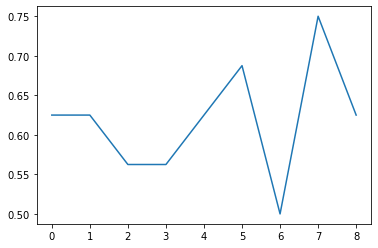

Saving iteration  9
Global Sparsity: 91.13%
Epoch [1/12], Step [400/782], Loss: 0.8795
Epoch [2/12], Step [400/782], Loss: 0.4416
Epoch [3/12], Step [400/782], Loss: 0.6200
Epoch [4/12], Step [400/782], Loss: 0.2458
Epoch [5/12], Step [400/782], Loss: 0.2328
Epoch [6/12], Step [400/782], Loss: 0.2036
Epoch [7/12], Step [400/782], Loss: 0.2709
Epoch [8/12], Step [400/782], Loss: 0.2137
Epoch [9/12], Step [400/782], Loss: 0.1468
Epoch [10/12], Step [400/782], Loss: 0.1685
Epoch [11/12], Step [400/782], Loss: 0.0660
Epoch [12/12], Step [400/782], Loss: 0.1176
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.69


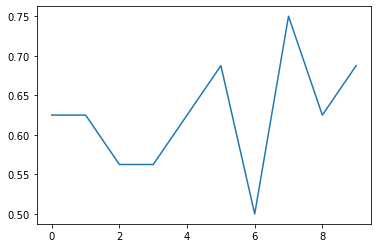

Saving iteration  10
Global Sparsity: 92.91%
Epoch [1/12], Step [400/782], Loss: 1.0621
Epoch [2/12], Step [400/782], Loss: 0.6382
Epoch [3/12], Step [400/782], Loss: 0.5404
Epoch [4/12], Step [400/782], Loss: 0.3547
Epoch [5/12], Step [400/782], Loss: 0.5114
Epoch [6/12], Step [400/782], Loss: 0.5085
Epoch [7/12], Step [400/782], Loss: 0.2359
Epoch [8/12], Step [400/782], Loss: 0.2568
Epoch [9/12], Step [400/782], Loss: 0.2394
Epoch [10/12], Step [400/782], Loss: 0.2697
Epoch [11/12], Step [400/782], Loss: 0.2447
Epoch [12/12], Step [400/782], Loss: 0.2163
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.44


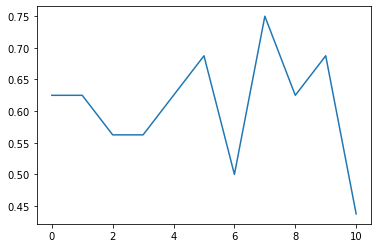

Saving iteration  11
Global Sparsity: 94.33%
Epoch [1/12], Step [400/782], Loss: 0.8958
Epoch [2/12], Step [400/782], Loss: 0.6103
Epoch [3/12], Step [400/782], Loss: 0.4577
Epoch [4/12], Step [400/782], Loss: 0.3960
Epoch [5/12], Step [400/782], Loss: 0.3277
Epoch [6/12], Step [400/782], Loss: 0.3881
Epoch [7/12], Step [400/782], Loss: 0.3361
Epoch [8/12], Step [400/782], Loss: 0.3581
Epoch [9/12], Step [400/782], Loss: 0.2793
Epoch [10/12], Step [400/782], Loss: 0.4529
Epoch [11/12], Step [400/782], Loss: 0.3717
Epoch [12/12], Step [400/782], Loss: 0.3422
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.62


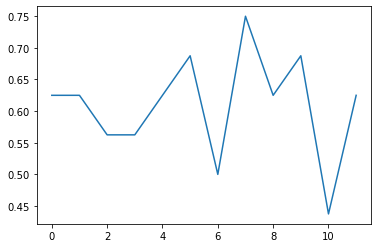

Saving iteration  12
Global Sparsity: 95.46%
Epoch [1/12], Step [400/782], Loss: 0.7484
Epoch [2/12], Step [400/782], Loss: 0.7179
Epoch [3/12], Step [400/782], Loss: 0.5633
Epoch [4/12], Step [400/782], Loss: 0.6230
Epoch [5/12], Step [400/782], Loss: 0.5129
Epoch [6/12], Step [400/782], Loss: 0.4482
Epoch [7/12], Step [400/782], Loss: 0.3257
Epoch [8/12], Step [400/782], Loss: 0.2600
Epoch [9/12], Step [400/782], Loss: 0.4171
Epoch [10/12], Step [400/782], Loss: 0.2622
Epoch [11/12], Step [400/782], Loss: 0.7497
Epoch [12/12], Step [400/782], Loss: 0.4941
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.56


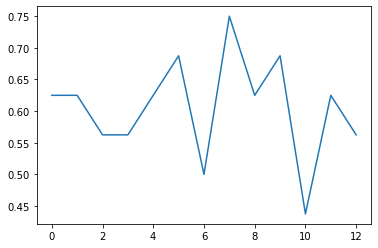

Saving iteration  13
Global Sparsity: 96.37%
Epoch [1/12], Step [400/782], Loss: 0.9335
Epoch [2/12], Step [400/782], Loss: 0.5816
Epoch [3/12], Step [400/782], Loss: 0.6816
Epoch [4/12], Step [400/782], Loss: 0.5728
Epoch [5/12], Step [400/782], Loss: 0.4286
Epoch [6/12], Step [400/782], Loss: 0.7778
Epoch [7/12], Step [400/782], Loss: 0.5150
Epoch [8/12], Step [400/782], Loss: 0.5822
Epoch [9/12], Step [400/782], Loss: 0.5238
Epoch [10/12], Step [400/782], Loss: 0.4981
Epoch [11/12], Step [400/782], Loss: 0.4075
Epoch [12/12], Step [400/782], Loss: 0.5395
model:  <class '__main__.LeNet'>
test_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Test Accuracy of the model on the 10000 test images: 0.56


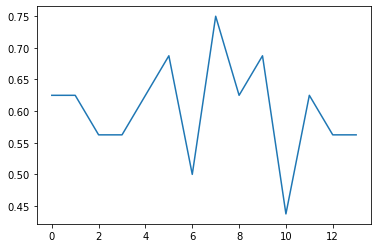

Saving iteration  14
Global Sparsity: 97.10%


KeyboardInterrupt: 

In [6]:
#Generate Tickets

max_growth = 50
model = LeNet(max_growth = max_growth)
find_ticket(model, 'CIFAR10', train_loader, test_loader, num_epochs=12, prune_amount=0.2, end_iter=30)